In [1]:
import numpy as np
import gzip
import struct
import pickle
from matplotlib import pyplot as plt

In [2]:
import urllib.request

# urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "train_features.gz")
# urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "test_features.gz")


def get_features(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
def plot_image(image):
    plt.imshow(image.reshape((28,28)), cmap="gray")
    
features = get_features("train_features.gz").reshape((60000, 784))
features = features / 255
features = features.astype(np.float32)
test = get_features("test_features.gz").reshape((10000, 784))
test = test.astype(np.float32)

C:\Users\marco\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(0 - x))
# def sigmoid(x):
#     return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
# def sigmoid(x):
#     return np.vectorize(lambda k: 1 / (1 + np.exp(-k)) if k >= 0 else np.exp(k) / (1 + np.exp(k)))(x)

# def d_sigmoid(x):
#     return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(x,0)

def d_relu(x):
    return np.where(x > 0, np.full(np.shape(x), 1), np.full(np.shape(x), 0))

# def leaky_relu(x, a=0.01):
#     _leaky_relu = lambda k: k if k > 0 else a*k
#     return np.vectorize(_leaky_relu)(x)

# def d_leaky_relu(x, a=0.01):
#     _d_leaky_relu = lambda k: 1 if k > 0 else a
#     return np.vectorize(_d_leaky_relu)(x)

# def tanh(x):
#     return np.tanh(x)

# def d_tanh(x):
#     return 1.0 - np.tanh(x)**2

def squared_loss(y, x):
    return (y - x) ** 2 / 2

def d_squared_loss(y, x):
    return - (y - x)

def cross_entropy_loss(x,y):
    return -x*np.log(y) - (1-x)*np.log(1-y)

def d_cross_entropy_loss(x,y):
    return ((1-x)/(1-y)) - (x/y)

In [4]:
def run(xs, w_1, w_2, b_1, b_2, no_training=False):
    """
    :param x: the matrix of input data, shape (N, D)
    """
    N = xs.shape[1]
    D = xs.shape[0]
    f1 = w_1 @ xs
    f2 = (b_1 + f1.T).T
    f3 = relu(f2)
    f4 = w_2 @ f3
    f5 = (b_2 + f4.T).T
    f6 = sigmoid(f5)
    f7 = cross_entropy_loss(xs, f6)
#     f8 = np.sum(f7, axis=0)
    f9 = np.sum(f7)
    f10 = f9 / N
    if no_training:
        return (f6, f10)
    t10 = 1
    t9 = 1 / N
    t8 = np.full((N), 1 / N)
    t7 = np.full((D, N), 1 / N)
    t6 = d_cross_entropy_loss(xs, f6) * t7
    t5 = (f6*(1-f6)) * t6
    t4 = t5
    tb2 = np.sum(t5, axis=1)

    t3 = w_2.T @ t4
    tw2 = (f3 @ t4.T).T

    t2 = d_relu(f2) * t3

    t1 = t2
    tb1 = np.sum(t2, axis=1)
    tw1 = t1 @ xs.T
    return f6, tw1, tw2, tb1, tb2, f10

In [5]:
def adam(weight, grad, k, m_prev, v_prev, b1=0.9, b2=0.999, l=0.0000000001, rate=0.05):
    m = b1 * m_prev + (1 - b1)*grad
    v = b2 * v_prev + (1 - b2)*(grad ** 2)
    
    m_hat = m / (1 - (b1 ** k))
    v_hat = v / (1 - (b2 ** k))
    weight -= (rate / (np.sqrt(v_hat) + l))*m_hat
    return (k+1, m, v)


In [6]:
def create_weight(shape):
    stdv = 1. / np.sqrt(shape[-1])
    return np.random.uniform(-stdv, stdv, shape).astype(np.float32)
#     rand(Uniform(-stdv, stdv), dims...)
    # rand(Normal(0,1), dims...)

w1 = create_weight((30, 784))
w2 = create_weight((784, 30))
b1 = create_weight((30,))
b2 = create_weight((784,))

In [7]:
past_epochs = []
past_loss_values = []

epochs = 100
previous_runnings = [[1,0,0] for i in range(4)]
weights = [w1,w2,b1,b2]

for i in range(epochs):
    res, grad_w1, grad_w2, grad_b1, grad_b2, loss = run(features.T, w1, w2, b1, b2)
    grads = [grad_w1, grad_w2, grad_b1, grad_b2]
    for (j, (weight, previous_running, grad)) in enumerate(zip(weights, previous_runnings, grads)):
        k, m, v = previous_running
        previous_runnings[j] = adam(weight, grad, k, m, v)
    if (i + 1) % 10 == 0:
        print("SAVING WEIGHTS")
        pickle.dump(weights, open("weight_cross.p", "wb"))
    past_epochs.append(i)
    past_loss_values.append(loss)
    print(i, loss)

0 543.4375666666666
1 438.3323
2 299.6861333333333
3 272.55898333333334
4 264.7751333333333
5 240.62348333333333
6 220.0133
7 217.76268333333334
8 208.76611666666668
SAVING WEIGHTS
9 203.59366666666668
10 201.29456666666667
11 199.37578333333335
12 193.6261
13 189.80998333333332
14 187.26255
15 183.5046
16 179.59755
17 176.28836666666666
18 173.6444
SAVING WEIGHTS
19 171.43688333333333
20 168.90815
21 166.74846666666667
22 164.77723333333333
23 162.59606666666667
24 160.4056
25 158.36896666666667
26 156.36368333333334
27 154.7274
28 153.13781666666668
SAVING WEIGHTS
29 151.51111666666668
30 150.24033333333333
31 148.8809
32 147.38868333333335
33 146.23833333333334
34 145.03426666666667
35 143.79271666666668
36 142.70578333333333
37 141.50606666666667
38 140.54203333333334
SAVING WEIGHTS
39 139.43669166666666
40 138.4902
41 137.611525
42 136.68203333333332
43 135.91669166666668
44 134.75215833333334
45 134.59810833333333
46 133.77205833333332
47 133.24875833333334
48 131.75333333333333


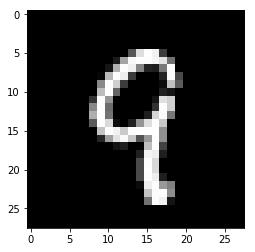

In [15]:
index = 7641
img = test[index:index+1, :]

plot_image(img)
# test = run(features.T[:,1:108], w1, w2, b1, b2)

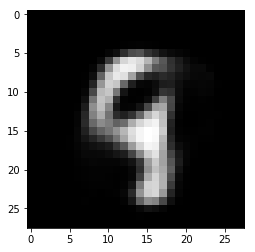

In [16]:
res_img, grad_w1, grad_w2, grad_b1, grad_b2, loss = run((img/255).T, w1, w2, b1, b2)
plot_image(res_img*255)

In [10]:
# pickle.dump(weights, open("weight.p", "wb"))